# 17 - On-the-fly discrete Fourier transform

In this notebook, we show how to compute Fourier modes during the propagation of the wavefield (on-the-fly) using the discrete Fourier transform (DFT). This method is known to be a memory efficient way to compute gradients for seismic inversion as only a few model-size Fourier modes are necessary instead of the full time history.

The method illustrate the forward modeling to implement. the method in the following paper:

- *Compressive least-squares migration with on-the-fly Fourier transforms*, Philipp A. Witte, Mathias Louboutin, Fabio Luporini, Gerard J. Gorman, and Felix J. Herrmann, 2019, Geophysics, 84(5), R655-R672. [DOI](https://doi.org/10.1190/geo2018-0490.1)

## Theory

The Fourier transform is a mathematical operation that transforms a function of time (or space) into a function of frequency. In the context of wave propagation, it allows us to analyze the frequency content of the wavefield.

The discrete Fourier transform (DFT) is a specific kind of Fourier transform used for discrete data. It is defined as:

$$ X_k = \sum_{n=0}^{N-1} x_n e^{-i 2 \pi k n / N} $$

where:
-  $X_k$ is the DFT of the sequence $x_n$ 
-  $N$ is the number of samples
-  $k$ is the frequency index
-  $n$ is the time index

In seismic applications, the DFT can be used to compute the frequency components of the wavefield as it propagates through the subsurface.

## On-the-fly Fourier Transform

The on-the-fly Fourier transform is a technique where the Fourier transform is computed during the wavefield propagation, rather than storing the entire time history of the wavefield. This approach is memory efficient and particularly useful for large-scale seismic inversion problems.

The key idea is to update the Fourier modes at each time step using the current wavefield values. This can be expressed as:

$$ F_k(t+\Delta t) = F_k(t) + u(t) e^{-i \omega_k t \Delta t} $$

where:
-  $F_k(t)$ is the Fourier mode at frequency $\omega_k$ and time $t$ 
-  $u(t)$ is the wavefield at time $t$
-  $\Delta t$ is the time step

By updating the Fourier modes on-the-fly, we avoid the need to store the entire wavefield history, thus saving memory.

In [1]:
from devito import *

from examples.seismic import demo_model, AcquisitionGeometry, plot_velocity

import matplotlib.pyplot as plt
from IPython.display import Code

In [2]:
# NBVAL_IGNORE_OUTPUT
model = demo_model('layers-isotropic', vp=3.0, origin=(0., 0.), shape=(101, 101), spacing=(10., 10.), nbl=40, nlayers=4)

Operator `initdamp` ran in 0.01 s


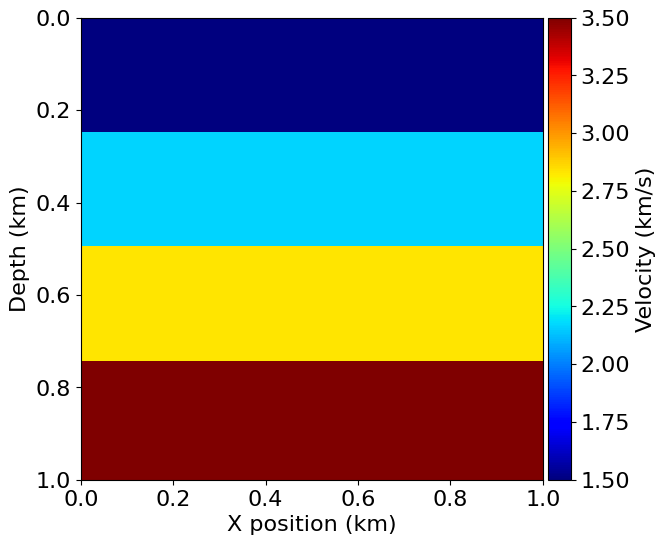

In [3]:
# NBVAL_IGNORE_OUTPUT
plot_velocity(model)

In [4]:
# NBVAL_IGNORE_OUTPUT
# Define acquisition geometry: source

# First, position source centrally in all dimensions, then set depth
src_coordinates = np.empty((1, 2))
src_coordinates[0, :] = np.array(model.domain_size) * .5
src_coordinates[0, -1] = 20.  # Depth is 20m


# Define acquisition geometry: receivers

# Initialize receivers for synthetic and imaging data
nreceivers = 101
rec_coordinates = np.empty((nreceivers, 2))
rec_coordinates[:, 0] = np.linspace(0, model.domain_size[0], num=nreceivers)
rec_coordinates[:, 1] = 30.

# Geometry
t0 = 0.
tn = 500.  # Simulation last 1 second (1000 ms)
dt = model.critical_dt
geometry = AcquisitionGeometry(model, rec_coordinates, src_coordinates, t0, tn, f0=.010, src_type='Ricker')

In [5]:
# Define the wavefield with the size of the model and the time dimension
u = TimeFunction(name="u", grid=model.grid, time_order=2, space_order=2)

# We can now write the PDE
pde = model.m * u.dt2 - u.laplace + model.damp * u.dt


# Stencil update
stencil = Eq(u.forward, solve(pde, u.forward))
stencil

Eq(u(t + dt, x, y), (-(-2.0*u(t, x, y)/dt**2 + u(t - dt, x, y)/dt**2)/vp(x, y)**2 + Derivative(u(t, x, y), (x, 2)) + Derivative(u(t, x, y), (y, 2)) + damp(x, y)*u(t, x, y)/dt)/(damp(x, y)/dt + 1/(dt**2*vp(x, y)**2)))

In [6]:
freq_mode = Function(name='freq_modes', grid=model.grid, space_order=0, dtype=np.complex64)
freq = .01  # Compute 10Hz slice
omega = 2 * np.pi * freq

basis = exp(-1j * omega * model.grid.time_dim * model.grid.time_dim.spacing)
dft = [Inc(freq_mode, basis * u)]

In [7]:
# Finally we define the source injection and receiver read function to generate the corresponding code
src = geometry.src
src_term = src.inject(field=u.forward, expr=src * dt**2 / model.m)

# Create interpolation expression for receivers
rec = geometry.rec
rec_term = rec.interpolate(expr=u.forward)

In [8]:
op = Operator([stencil] + src_term + rec_term + dft, subs=model.spacing_map)

In [9]:
# NBVAL_IGNORE_OUTPUT
Code(str(op.ccode), language='C')

/* Devito generated code for Operator `Kernel` */

#define _POSIX_C_SOURCE 200809L
#define START(S) struct timeval start_ ## S , end_ ## S ; gettimeofday(&start_ ## S , NULL);
#define STOP(S,T) gettimeofday(&end_ ## S, NULL); T->S += (double)(end_ ## S .tv_sec-start_ ## S.tv_sec)+(double)(end_ ## S .tv_usec-start_ ## S .tv_usec)/1000000;
#define MAX(a,b) (((a) > (b)) ? (a) : (b))

#include "stdlib.h"
#include "math.h"
#include "sys/time.h"
#include "xmmintrin.h"
#include "pmmintrin.h"
#include "omp.h"
#include "complex.h"

struct dataobj
{
  void *restrict data;
  int * size;
  unsigned long nbytes;
  unsigned long * npsize;
  unsigned long * dsize;
  int * hsize;
  int * hofs;
  int * oofs;
  void * dmap;
} ;

struct profiler
{
  double section0;
  double section1;
  double section2;
} ;


int Kernel(struct dataobj *restrict damp_vec, struct dataobj *restrict freq_modes_vec, struct dataobj *restrict rec_vec, struct dataobj *restrict rec_coords_vec, struct dataobj *restrict src_vec, struct dataobj *restrict src_coords_vec, struct dataobj *restrict u_vec, struct dataobj *restrict vp_vec, const int x_M, const int x_m, const int y_M, const int y_m, const float dt, const float o_x, const float o_y, const int p_rec_M, const int p_rec_m, const int p_src_M, const int p_src_m, const int time_M, const int time_m, const int nthreads, const int nthreads_nonaffine, struct profiler * timers)
{
  float (*restrict damp)[damp_vec->size[1]] __attribute__ ((aligned (64))) = (float (*)[damp_vec->size[1]]) damp_vec->data;
  float _Complex (*restrict freq_modes)[freq_modes_vec->size[1]] __attribute__ ((aligned (64))) = (float _Complex (*)[freq_modes_vec->size[1]]) freq_modes_vec->data;
  float (*restrict rec)[rec_vec->size[1]] __attribute__ ((aligned (64))) = (float (*)[rec_vec->size[1]]) rec_vec->data;
  float (*restrict rec_coords)[rec_coords_vec->size[1]] __attribute__ ((aligned (64))) = (float (*)[rec_coords_vec->size[1]]) rec_coords_vec->data;
  float (*restrict src)[src_vec->size[1]] __attribute__ ((aligned (64))) = (float (*)[src_vec->size[1]]) src_vec->data;
  float (*restrict src_coords)[src_coords_vec->size[1]] __attribute__ ((aligned (64))) = (float (*)[src_coords_vec->size[1]]) src_coords_vec->data;
  float (*restrict u)[u_vec->size[1]][u_vec->size[2]] __attribute__ ((aligned (64))) = (float (*)[u_vec->size[1]][u_vec->size[2]]) u_vec->data;
  float (*restrict vp)[vp_vec->size[1]] __attribute__ ((aligned (64))) = (float (*)[vp_vec->size[1]]) vp_vec->data;

  /* Flush denormal numbers to zero in hardware */
  _MM_SET_DENORMALS_ZERO_MODE(_MM_DENORMALS_ZERO_ON);
  _MM_SET_FLUSH_ZERO_MODE(_MM_FLUSH_ZERO_ON);

  float _Complex r2 = 1.0F/(dt*dt);
  float _Complex r3 = 1.0F/dt;
  for (int time = time_m, t0 = (time)%(3), t1 = (time + 2)%(3), t2 = (time + 1)%(3); time <= time_M; time += 1, t0 = (time)%(3), t1 = (time + 2)%(3), t2 = (time + 1)%(3))
  {
    float _Complex r1 = cexpf(-6.28318530717959e-2F*time*_Complex_I*dt);
    START(section0)
    #pragma omp parallel num_threads(nthreads)
    {
      #pragma omp for schedule(dynamic,1)
      for (int x = x_m; x <= x_M; x += 1)
      {
        #pragma omp simd aligned(damp,freq_modes,u,vp:32)
        for (int y = y_m; y <= y_M; y += 1)
        {
          float _Complex r4 = 1.0F/(vp[x + 2][y + 2]*vp[x + 2][y + 2]);
          u[t2][x + 2][y + 2] = (-r4*(-2.0F*r2*u[t0][x + 2][y + 2] + r2*u[t1][x + 2][y + 2]) + r3*damp[x + 2][y + 2]*u[t0][x + 2][y + 2] + 1.0e-2F*(u[t0][x + 1][y + 2] + u[t0][x + 2][y + 1] + u[t0][x + 2][y + 3] + u[t0][x + 3][y + 2]) - 3.99999991e-2F*u[t0][x + 2][y + 2])/(r4*r2 + r3*damp[x + 2][y + 2]);
          freq_modes[x][y] += r1*u[t0][x + 2][y + 2];
        }
      }
    }
    STOP(section0,timers)

    START(section1)
    #pragma omp parallel num_threads(nthreads_nonaffine)
    {
      int chunk_size = (int)(MAX(1, (int)((1.0/3.0)*(p_src_M - p_src_m + 1)/nthreads_nonaffine)));
      #pragma omp for schedule(dynamic,chunk_size)
      for (int p_src = p_src_m; p_src <= p_src_M;

In [10]:
# NBVAL_IGNORE_OUTPUT
op(dt=model.critical_dt)

Operator `Kernel` ran in 0.02 s


PerformanceSummary([(PerfKey(name='section0', rank=None),
                     PerfEntry(time=0.01217100000000002, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[])),
                    (PerfKey(name='section1', rank=None),
                     PerfEntry(time=0.0015440000000000067, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[])),
                    (PerfKey(name='section2', rank=None),
                     PerfEntry(time=0.0022019999999999943, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[]))])

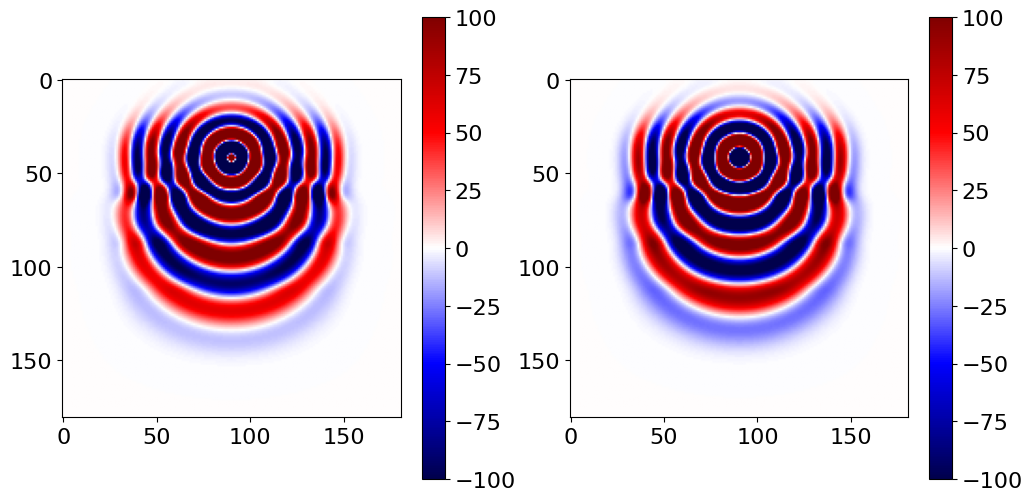

In [11]:
# NBVAL_IGNORE_OUTPUT
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(np.real(freq_mode.data.T), cmap='seismic', vmin=-1e2, vmax=1e2)
plt.colorbar()
plt.subplot(1, 2, 2)
plt.imshow(np.imag(freq_mode.data.T), cmap='seismic', vmin=-1e2, vmax=1e2)
plt.colorbar()
plt.show()

In [12]:
assert np.isclose(norm(freq_mode), 13873.049, atol=0, rtol=1e-4)
assert np.isclose(norm(u), 323.74207, atol=0, rtol=1e-4)

# Multiple frequencies

We can now extend the method to multiple frequencies. The idea is to compute the Fourier modes for a set of frequencies simultaneously. This can be done by adding a frequency dimension to the Fourier modes and updating them for each frequency at each time step.


In [13]:
nfreq = 5
f = Dimension(name='f')

frequencies = Function(name='frequencies', dimensions=(f,), shape=(nfreq,), dtype=np.float32)
frequencies.data[:] = np.linspace(0.005, 0.015, num=nfreq)

freq_modes = Function(name='freq_modes', grid=model.grid, space_order=0, dtype=np.complex64,
                      dimensions=(f, *model.grid.dimensions), shape=(nfreq, *model.grid.shape))

omega = 2 * np.pi * frequencies
basis = exp(-1j * omega * model.grid.time_dim * model.grid.time_dim.spacing)
dfts = [Inc(freq_modes, basis * u)]

In [14]:
op = Operator([stencil] + src_term + rec_term + dfts, subs=model.spacing_map)

In [15]:
# NBVAL_IGNORE_OUTPUT
Code(str(op.ccode), language='C')

/* Devito generated code for Operator `Kernel` */

#define _POSIX_C_SOURCE 200809L
#define START(S) struct timeval start_ ## S , end_ ## S ; gettimeofday(&start_ ## S , NULL);
#define STOP(S,T) gettimeofday(&end_ ## S, NULL); T->S += (double)(end_ ## S .tv_sec-start_ ## S.tv_sec)+(double)(end_ ## S .tv_usec-start_ ## S .tv_usec)/1000000;
#define MAX(a,b) (((a) > (b)) ? (a) : (b))
#define MIN(a,b) (((a) < (b)) ? (a) : (b))

#include "stdlib.h"
#include "math.h"
#include "sys/time.h"
#include "xmmintrin.h"
#include "pmmintrin.h"
#include "omp.h"
#include "complex.h"

struct dataobj
{
  void *restrict data;
  int * size;
  unsigned long nbytes;
  unsigned long * npsize;
  unsigned long * dsize;
  int * hsize;
  int * hofs;
  int * oofs;
  void * dmap;
} ;

struct profiler
{
  double section0;
  double section1;
  double section2;
  double section3;
  double section4;
} ;


int Kernel(struct dataobj *restrict damp_vec, struct dataobj *restrict freq_modes_vec, struct dataobj *restrict frequencies_vec, struct dataobj *restrict rec_vec, struct dataobj *restrict rec_coords_vec, struct dataobj *restrict src_vec, struct dataobj *restrict src_coords_vec, struct dataobj *restrict u_vec, struct dataobj *restrict vp_vec, const int x_M, const int x_m, const int y_M, const int y_m, const float dt, const int f0_blk0_size, const int f_M, const int f_m, const float o_x, const float o_y, const int p_rec_M, const int p_rec_m, const int p_src_M, const int p_src_m, const int time_M, const int time_m, const int x0_blk0_size, const int nthreads, const int nthreads_nonaffine, const int f_size, struct profiler * timers)
{
  float _Complex *restrict r1_vec __attribute__ ((aligned (64)));
  posix_memalign((void**)(&r1_vec),64,sizeof(float _Complex)*(long)f_size);

  float (*restrict damp)[damp_vec->size[1]] __attribute__ ((aligned (64))) = (float (*)[damp_vec->size[1]]) damp_vec->data;
  float _Complex (*restrict freq_modes)[freq_modes_vec->size[1]][freq_modes_vec->size[2]] __attribute__ ((aligned (64))) = (float _Complex (*)[freq_modes_vec->size[1]][freq_modes_vec->size[2]]) freq_modes_vec->data;
  float *restrict frequencies __attribute__ ((aligned (64))) = (float (*)) frequencies_vec->data;
  float _Complex *restrict r1 __attribute__ ((aligned (64))) = (float _Complex (*)) r1_vec;
  float (*restrict rec)[rec_vec->size[1]] __attribute__ ((aligned (64))) = (float (*)[rec_vec->size[1]]) rec_vec->data;
  float (*restrict rec_coords)[rec_coords_vec->size[1]] __attribute__ ((aligned (64))) = (float (*)[rec_coords_vec->size[1]]) rec_coords_vec->data;
  float (*restrict src)[src_vec->size[1]] __attribute__ ((aligned (64))) = (float (*)[src_vec->size[1]]) src_vec->data;
  float (*restrict src_coords)[src_coords_vec->size[1]] __attribute__ ((aligned (64))) = (float (*)[src_coords_vec->size[1]]) src_coords_vec->data;
  float (*restrict u)[u_vec->size[1]][u_vec->size[2]] __attribute__ ((aligned (64))) = (float (*)[u_vec->size[1]][u_vec->size[2]]) u_vec->data;
  float (*restrict vp)[vp_vec->size[1]] __attribute__ ((aligned (64))) = (float (*)[vp_vec->size[1]]) vp_vec->data;

  /* Flush denormal numbers to zero in hardware */
  _MM_SET_DENORMALS_ZERO_MODE(_MM_DENORMALS_ZERO_ON);
  _MM_SET_FLUSH_ZERO_MODE(_MM_FLUSH_ZERO_ON);

  float r2 = 1.0F/(dt*dt);
  float r3 = 1.0F/dt;
  for (int time = time_m, t0 = (time)%(3), t1 = (time + 2)%(3), t2 = (time + 1)%(3); time <= time_M; time += 1, t0 = (time)%(3), t1 = (time + 2)%(3), t2 = (time + 1)%(3))
  {
    START(section0)
    #pragma omp parallel num_threads(nthreads)
    {
      #pragma omp for schedule(dynamic,1)
      for (int x = x_m; x <= x_M; x += 1)
      {
        #pragma omp simd aligned(damp,u,vp:32)
        for (int y = y_m; y <= y_M; y += 1)
        {
          float r4 = 1.0F/(vp[x + 2][y + 2]*vp[x + 2][y + 2]);
          u[t2][x + 2][y + 2] = (-r4*(-2.0F*r2*u[t0][x + 2][y + 2] + r2*u[t1][x + 2][y + 2]) + r3*damp[x + 2][y + 2]*u[t0][x + 2][y + 2] + 1.0e-2F*(u[t0][x + 1][y + 2] + u[t0][x + 2][y + 1] + u[t0][x + 

In [16]:
# NBVAL_IGNORE_OUTPUT
u.data.fill(0)
op(dt=model.critical_dt)

Operator `Kernel` ran in 0.02 s


PerformanceSummary([(PerfKey(name='section0', rank=None),
                     PerfEntry(time=0.005692999999999984, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[])),
                    (PerfKey(name='section1', rank=None),
                     PerfEntry(time=0.0011870000000000019, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[])),
                    (PerfKey(name='section2', rank=None),
                     PerfEntry(time=0.001855000000000043, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[])),
                    (PerfKey(name='section3', rank=None),
                     PerfEntry(time=0.0009519999999999956, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[])),
                    (PerfKey(name='section4', rank=None),
                     PerfEntry(time=0.009509999999999996, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[]))])

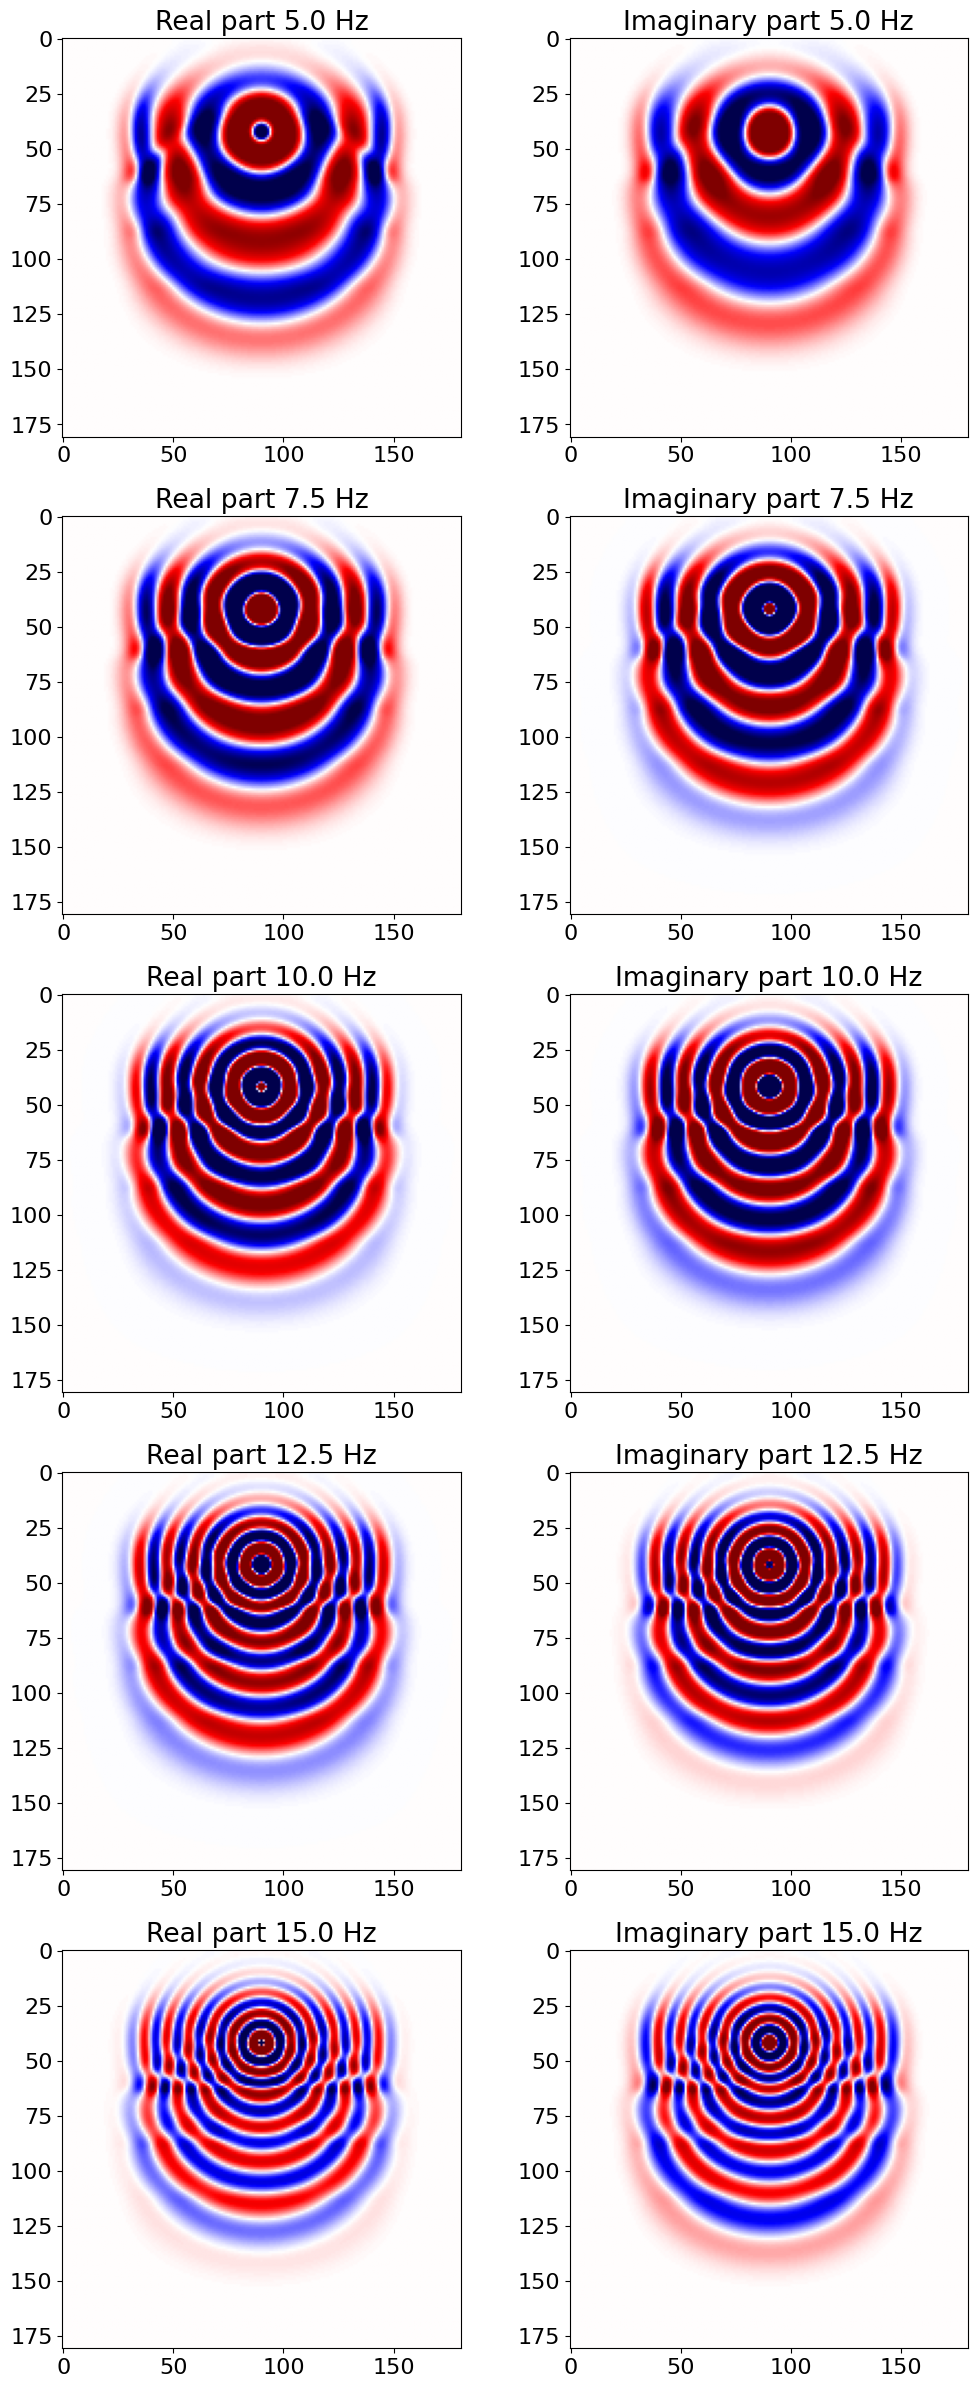

In [17]:
# NBVAL_IGNORE_OUTPUT
plt.figure(figsize=(12, 30))
for i in range(5):
    plt.subplot(5, 2, 2*i+1)
    plt.imshow(np.real(freq_modes.data[i].T), cmap='seismic', vmin=-1e2, vmax=1e2)
    plt.title(f'Real part {1e3*frequencies.data[i]} Hz')
    plt.subplot(5, 2, 2*i+2)
    plt.imshow(np.imag(freq_modes.data[i].T), cmap='seismic', vmin=-1e2, vmax=1e2)
    plt.title(f'Imaginary part {1e3*frequencies.data[i]} Hz')

plt.show()

In [18]:
assert np.isclose(norm(freq_modes), 26016.113, atol=0, rtol=1e-4)